## FRAUD DETECTION

A continuación se presenta el ánalisis y modelado resultante de transacciones reales de comercio electrónico de Vesta quienes se encargan de ofrecer soluciones de pago garantizadas de comercio electrónico. Vesta es pionera en el proceso de transacciones de pago con tarjeta no presente (CNP) totalmente garantizadas para la industria de telecomunicaciones.

### EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
fraude_identity_path = r"C:\MariaP\MachineLearning\Parcial\Data\fraud\train_identity.csv"
fraude_identity = pd.read_csv(fraude_identity_path)

In [4]:
fraude_transaction_path = r"C:\MariaP\MachineLearning\Parcial\Data\fraud\train_transaction.csv"
fraude_transaction = pd.read_csv(fraude_transaction_path)

In [5]:
fraude_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
fraude_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se realiza la unión de la información y posteriormente se reduce el uso de la memoria.

In [7]:
fraude = pd.merge(fraude_transaction, fraude_identity, on ='TransactionID', how = "left")

In [8]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

reduce_mem_usage(fraude)

Initial memory usage of dataframe is 2567.09 MB/2.51 GB
Memory usage after optimization is: 525.70 MB/0.51 GB
Decreased by 79.5%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Número de observaciones
print("Número de observaciones Transaction{}".format(fraude_transaction.shape))
print("Número de observaciones Identity{}".format(fraude_identity.shape))


Número de observaciones Transaction(590540, 394)
Número de observaciones Identity(144233, 41)


El número de transacciones ID no es el mismo para la base de datos Identity, esto trae como consecuencia muchos faltantes.

In [55]:
#Tipo de variables
fraude.info()

#La mayoría de variables son númericas, mientras que solo hay 31 de tipo categóricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 525.6 MB


Se realizará la eliminación de columnas y filas por faltantes y por criterio propio (ej: se eliminan la columna TransactionID que es un identificador incremental y el TransactionDT que también es incremental al ser tiempo transcurrido desde un punto de referencia).

In [56]:
pd.set_option('display.max_columns', None)
columnas = fraude.columns.tolist()
for columna in columnas:
    print(columna)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

Se eliminarán las columnas que tengan un % de faltantes mayor al 40% por las siguientes razones:

- La imputación tendría un efecto bastante influyente puesto que más del el 40% de los datos serían ajustados.
- Si en la práctica no hay información de las variables, no es tan conveniente utilizar variables que no aportan mucha información.

In [57]:
valores_faltantes = fraude.isnull().sum()
porcentaje_faltantes = (valores_faltantes/fraude.shape[0])*100
Faltantes = pd.DataFrame({'Columna': valores_faltantes.index, 'Valores Faltantes': valores_faltantes, 'Porcentaje Faltantes': porcentaje_faltantes})
Faltantes.sort_values(by = "Porcentaje Faltantes", ascending = False)

,Columna,Valores Faltantes,Porcentaje Faltantes
id_24,id_24,585793,99.196159
id_25,id_25,585408,99.130965
id_07,id_07,585385,99.127070
id_08,id_08,585385,99.127070
id_21,id_21,585381,99.126393
...,...,...,...
C3,C3,0,0.000000
C2,C2,0,0.000000
C1,C1,0,0.000000
isFraud,isFraud,0,0.000000


In [58]:
#Se van a eliminar las columnas que tengan un % de faltantes superior a 40% (umbral personal)
columnas_a_eliminar = porcentaje_faltantes[porcentaje_faltantes > 40].index.tolist()
fraude_drop = fraude.drop(columns=columnas_a_eliminar)
fraude_drop.shape

(590540, 202)

In [59]:
#Eliminar las columnas del dominio del correo electrónico

fraude_drop = fraude_drop.drop(["P_emaildomain", "TransactionID", "TransactionDT"], axis = 1)
fraude_drop.shape

(590540, 199)

In [60]:
#Se eliminarán también las filas que tengan más del 40% de datos faltantes

porcentaje_faltantes_por_fila = (fraude_drop.isnull().sum(axis=1) / len(fraude_drop.columns)) * 100
filas_a_eliminar = porcentaje_faltantes_por_fila[porcentaje_faltantes_por_fila > 40].index.tolist()
fraude_drop = fraude_drop.drop(index=filas_a_eliminar)
fraude_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522058 entries, 0 to 590539
Columns: 199 entries, isFraud to V321
dtypes: category(4), float16(175), float32(18), int16(1), int8(1)
memory usage: 217.6 MB


In [61]:
from scipy.stats import chi2_contingency

In [62]:
columnas_categoricas = fraude_drop.select_dtypes(include=['category']).columns.tolist()

resultados_chi2 = {}

for col1 in columnas_categoricas:
    for col2 in columnas_categoricas:
        if col1 != col2:
            # Crea una tabla de contingencia
            tabla_contingencia = pd.crosstab(fraude_drop[col1], fraude[col2])
            
            # Aplica la prueba de chi-cuadrado
            chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
            
            # Almacena los resultados en el diccionario
            resultados_chi2[(col1, col2)] = {'Chi2': chi2, 'p-valor': p, 'Grados de libertad': dof, 'Frecuencias esperadas': expected}


In [63]:
columnas_relacionadas = set()

# Filtrar las columnas relacionadas con p-valor < 0.05
for cols, resultado in resultados_chi2.items():
    if resultado['p-valor'] < 0.05:
        columnas_relacionadas.add(cols[0])  # Agrega la primera columna
        columnas_relacionadas.add(cols[1])  # Agrega la segunda columna

# Convertir el conjunto en una lista (si lo deseas)
columnas_relacionadas = list(columnas_relacionadas)

# Imprimir las columnas relacionadas
print("Columnas relacionadas con p-valor < 0.05:")
print(columnas_relacionadas)

Columnas relacionadas con p-valor < 0.05:
['ProductCD', 'M6', 'card6', 'card4']


Se eliminará la columna ProductCD y card6

In [65]:
fraude_drop = fraude_drop.drop(["ProductCD", "M6"], axis = 1)

In [66]:
columnas_categoricas = fraude_drop.select_dtypes(include=['category']).columns.tolist()
fraude_drop = fraude_drop.dropna(subset=columnas_categoricas)
fraude_drop.shape

(520490, 197)

In [67]:
fraude_drop.isnull().sum().sort_values(ascending=False)

V46               100272
V37               100272
V47               100272
V52               100272
V51               100272
                   ...  
C12                    0
C13                    0
C14                    0
TransactionAmt         0
isFraud                0
Length: 197, dtype: int64

Imputación de nulos con la mediana

In [71]:
from sklearn.impute import SimpleImputer

columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()
imputer = SimpleImputer(strategy='median')

fraude_drop[columnas_numericas] = imputer.fit_transform(fraude_drop[columnas_numericas])

In [72]:
fraude_drop.isnull().sum().sort_values(ascending=False)

isFraud    0
V108       0
V110       0
V111       0
V112       0
          ..
V52        0
V53        0
V54        0
V55        0
V321       0
Length: 197, dtype: int64

In [42]:
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

### VIF

In [83]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Por tiempo computacional, haré el VIF por pedazos, si comparando menos variables dan VIF > 5 con seguridad al hacerlo con todas las variables también será mayor que 5.

In [84]:
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:10]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

  Variable         VIF
5      V17  114.006015
6      V18  105.412715
3      V15   76.213446
4      V16   72.142285
7      V19   30.137431
8      V20   29.096228
1      V13   17.730436
0      V12   16.809984
9      V21   14.146751
2      V14    6.516514


En vista que los VIF son muy grandes eliminaré varios al mismo tiempo, porque deben tener relación con varias variables.

In [85]:
fraude_drop = fraude_drop.drop(["V17", "V18"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:10]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

  Variable        VIF
3      V15  56.094780
4      V16  51.826529
5      V19  30.141597
6      V20  29.093686
2      V14  23.204205
7      V21  22.028861
9      V23  19.075445
8      V22  18.036449
1      V13  17.733976
0      V12  16.809364


In [86]:
fraude_drop = fraude_drop.drop(["V15", "V16", "V19", "V20", "V14", "V21"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:20]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable         VIF
5       V25  118.964844
6       V26  111.574957
11      V31   73.144561
12      V32   65.187499
3       V23   59.849234
4       V24   49.245343
16      V36   27.779070
15      V35   26.547462
13      V33   23.587404
1       V13   21.875335
9       V29   20.515290
0       V12   20.490388
10      V30   19.737683
14      V34   19.258825
7       V27   18.874107
8       V28   18.843776
17      V37   16.638578
18      V38   13.158047
2       V22    5.677836
19      V39    3.020775


In [87]:
fraude_drop = fraude_drop.drop(["V25", "V26", "V31", "V32", "V23", "V24", "V36", "V35", "V33", "V13", "V29", "V12"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:20]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable         VIF
14      V46  150.910028
15      V47   79.461120
9       V41   62.579150
12      V44   42.449660
13      V45   36.287203
5       V37   35.489168
10      V42   31.329951
6       V38   29.299340
17      V49   25.273422
16      V48   24.973960
11      V43   24.767805
7       V39   19.787779
1       V27   18.829888
2       V28   18.820489
8       V40   17.025004
18      V50    9.998011
19      V51    9.764268
4       V34    6.360675
0       V22    3.689287
3       V30    3.606215


In [88]:
fraude_drop = fraude_drop.drop(["V46", "V27", "V41", "V44", "V45", "V37", "V42", "V38", "V49", "V48", "V43"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:30]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable         VIF
14      V57  261.750703
28      V71  260.712104
15      V58  256.596188
29      V72  250.168467
23      V66   89.121450
24      V67   73.036979
22      V65   58.188394
6       V47   41.614719
16      V59   36.703205
18      V61   33.062320
19      V62   31.338085
20      V63   29.599616
17      V60   28.046939
12      V55   26.210758
27      V70   24.621999
26      V69   23.179053
8       V51   21.346861
21      V64   19.854561
9       V52   18.971438
11      V54   18.831156
4       V39   18.376690
13      V56   17.598262
10      V53   17.554736
5       V40   16.084842
7       V50   10.421921
2       V30    8.101184
3       V34    7.034961
0       V22    5.032858
25      V68    1.532684
1       V28    1.523874


In [89]:
fraude_drop = fraude_drop.drop(["V57", "V71", "V58", "V72", "V66", "V67", "V65", "V47", "V59", "V61", "V62", "V63", "V60", "V55", "V70", "V69", "V51",
                                "V64", "V52", "V54", "V39","V56", "V53"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:30]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable        VIF
27      V93  52.176473
26      V92  48.428655
20      V86  38.895659
16      V82  31.251188
18      V84  30.939438
17      V83  29.972725
21      V87  28.160665
11      V77  27.329466
19      V85  26.386106
14      V80  25.038514
15      V81  24.203767
25      V91  24.077816
24      V90  21.923129
12      V78  21.289963
28      V94  20.941186
7       V73  20.061382
13      V79  18.015679
10      V76  17.043956
9       V75  15.886139
22      V88  15.645462
8       V74  14.739767
5       V50  12.620375
2       V30   8.799873
3       V34   8.738561
4       V40   5.165317
0       V22   4.946166
23      V89   3.021583
1       V28   2.639712
6       V68   1.752818
29      V95   1.058829


In [90]:
fraude_drop = fraude_drop.drop(["V93", "V92", "V86", "V82", "V84", "V83", "V87", "V77", "V85", "V80", "V81", "V91", "V90", "V78", "V94", "V73", "V79",
                                "V76", "V75", "V88"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:20]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable           VIF
10      V96  7.876574e+06
16     V102  6.262711e+06
9       V95  2.785484e+06
15     V101  2.665999e+06
19     V105  5.522655e+04
13      V99  3.837525e+04
11      V97  9.263334e+03
17     V103  8.923249e+03
18     V104  2.480760e+03
12      V98  5.083347e+02
14     V100  1.710654e+01
5       V50  6.301908e+00
3       V34  6.194983e+00
7       V74  5.221004e+00
0       V22  3.485150e+00
4       V40  2.974950e+00
8       V89  2.974178e+00
1       V28  2.633228e+00
6       V68  1.752908e+00
2       V30  1.049954e+00


In [92]:
fraude_drop = fraude_drop.drop(["V96", "V102", "V95", "V101", "V105", "V99", "V97", "V103", "V104", "V98", "V100"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:20]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable          VIF
16     V113  1779.255032
14     V111  1641.017613
11     V108  1001.551845
13     V110   820.501910
15     V112   527.403654
17     V114   482.058293
19     V116   396.803018
12     V109   233.227568
10     V107   218.703063
18     V115   104.806118
5       V50     6.319880
3       V34     6.201719
7       V74     5.247359
0       V22     3.471043
4       V40     3.016343
8       V89     2.972140
1       V28     2.630712
6       V68     1.752066
2       V30     1.681470
9      V106     1.068827


In [93]:
fraude_drop = fraude_drop.drop(["V113", "V111", "V108", "V110", "V112", "V114", "V109", "V107", "V115"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:30]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable           VIF
20     V126  29074.290406
26     V132  27517.217607
13     V119   5778.123962
11     V117   4918.257448
22     V128   3129.707542
28     V134   2869.927191
14     V120   2337.736060
21     V127   2159.900375
16     V122   2116.403469
27     V133   2036.012233
12     V118   1630.817598
15     V121    510.391180
29     V135    314.583637
19     V125    103.631530
10     V116     94.940860
17     V123     80.583365
23     V129     68.488854
18     V124     27.550033
24     V130     17.963857
25     V131     16.127923
9      V106      7.962492
5       V50      6.345851
3       V34      6.205324
7       V74      5.250541
0       V22      3.476461
4       V40      3.028847
8       V89      3.021918
1       V28      2.679774
6       V68      1.825989
2       V30      1.695702


In [95]:
fraude_drop = fraude_drop.drop(["V126", "V132", "V119", "V117", "V128", "V134", "V120", "V127", "V122", "V133", "V118", "V121", "V135", "V125",
                                "V125", "V116", "V123", "V129", "V124", "V130", "V131"], axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:30]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable           VIF
13     V280  12137.147050
28     V295  10804.621296
12     V279   8550.326274
26     V293   8388.766211
27     V294    103.563381
24     V291     35.117359
10     V136     29.703062
9      V106     28.603410
25     V292     27.162614
20     V287     26.631344
11     V137     17.607969
29     V296     16.257807
22     V289      7.453304
21     V288      7.156230
23     V290      6.713951
5       V50      6.505183
3       V34      6.254060
7       V74      5.512292
15     V282      5.086767
17     V284      4.994006
18     V285      4.081380
16     V283      3.824424
0       V22      3.510494
4       V40      2.988340
8       V89      2.980756
1       V28      2.640102
14     V281      2.059950
6       V68      1.768803
19     V286      1.603774
2       V30      1.499791


In [96]:
columnas_alto_vif = vif_data[vif_data["VIF"] > 20]["Variable"].tolist()

fraude_drop = fraude_drop.drop(columnas_alto_vif, axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:30]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable         VIF
21     V298  100.779835
19     V296   67.130967
27     V304   27.956360
22     V299   24.793782
25     V302   18.532886
26     V303   10.035327
20     V297    7.553293
17     V289    7.432598
16     V288    7.227926
5       V50    6.732683
3       V34    6.496506
11     V282    6.446928
23     V300    5.960248
24     V301    5.650496
7       V74    5.611351
28     V305    5.565708
0       V22    4.723079
18     V290    3.995026
12     V283    3.833811
4       V40    3.555848
29     V306    3.332527
8       V89    2.976927
1       V28    2.633827
10     V281    2.363107
13     V284    2.129152
9      V137    1.782693
6       V68    1.764811
2       V30    1.735553
14     V285    1.734551
15     V286    1.598491


In [97]:
columnas_alto_vif = vif_data[vif_data["VIF"] > 20]["Variable"].tolist()

fraude_drop = fraude_drop.drop(columnas_alto_vif, axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:40]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable           VIF
25     V306  27360.958969
35     V316  25883.085955
26     V307  12617.450963
36     V317  10470.846840
27     V308   2520.891487
37     V318   2243.090033
38     V319    319.501192
29     V310     96.055742
39     V320     94.314907
28     V309     72.741645
34     V315     14.907154
31     V312     14.394491
17     V289     11.121462
32     V313     10.717797
16     V288     10.039460
22     V302      9.514532
9      V137      8.485686
5       V50      6.766992
11     V282      6.533918
3       V34      6.497439
24     V305      6.458649
30     V311      6.431564
23     V303      6.305890
20     V300      5.957494
18     V290      5.674463
21     V301      5.672836
7       V74      5.640645
0       V22      4.736203
33     V314      4.397176
12     V283      3.845217
4       V40      3.493602
19     V297      3.363571
14     V285      3.121140
13     V284      3.086205
8       V89      3.081638
1       V28      2.677198
10     V281      2.383682
15     V286 

Fui modificanado el umbral al notar que en su mayoría las variables siguen relacionandose entre sí

In [98]:
columnas_alto_vif = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()

fraude_drop = fraude_drop.drop(columnas_alto_vif, axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:30]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
20     V302  8.871147
25     V321  8.146987
9      V137  8.031460
5       V50  6.701094
3       V34  6.474425
11     V282  5.925031
18     V300  5.813666
19     V301  5.613493
7       V74  5.565215
22     V305  5.518826
21     V303  5.496257
0       V22  4.700767
16     V290  3.731760
4       V40  3.473447
8       V89  2.977621
12     V283  2.943345
1       V28  2.635160
10     V281  2.303433
13     V284  2.085752
17     V297  2.084991
6       V68  1.769674
2       V30  1.729920
15     V286  1.644873
14     V285  1.638984
24     V314  1.282311
23     V311  1.086873


In [99]:
fraude_drop = fraude_drop.drop("V302", axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:len(columnas_v)]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
24     V321  8.146908
9      V137  8.029641
5       V50  6.482280
3       V34  6.351998
11     V282  5.899619
18     V300  5.813782
19     V301  5.613422
7       V74  5.525488
21     V305  5.472453
0       V22  4.080313
16     V290  3.656912
20     V303  3.298147
4       V40  3.243489
8       V89  2.974400
12     V283  2.942489
1       V28  2.635095
10     V281  2.299862
13     V284  2.083581
17     V297  2.082682
6       V68  1.768985
2       V30  1.728375
15     V286  1.644532
14     V285  1.636652
23     V314  1.280431
22     V311  1.086840


In [100]:
fraude_drop = fraude_drop.drop("V321", axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:len(columnas_v)]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
5       V50  6.481632
3       V34  6.351998
11     V282  5.899553
18     V300  5.792209
19     V301  5.611375
7       V74  5.525442
21     V305  5.464105
0       V22  4.080146
16     V290  3.644801
20     V303  3.292294
4       V40  3.243010
8       V89  2.974163
12     V283  2.942498
1       V28  2.633762
10     V281  2.299478
13     V284  2.083575
17     V297  2.047968
6       V68  1.768601
2       V30  1.728373
9      V137  1.654357
15     V286  1.644522
14     V285  1.636608
23     V314  1.280320
22     V311  1.086840


In [101]:
fraude_drop = fraude_drop.drop("V50", axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:len(columnas_v)]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
10     V282  5.886851
3       V34  5.822359
17     V300  5.791899
18     V301  5.611383
20     V305  5.454727
6       V74  5.222301
0       V22  3.820407
15     V290  3.640034
19     V303  3.285713
7       V89  2.974114
11     V283  2.928800
4       V40  2.774156
1       V28  2.632291
9      V281  2.287698
12     V284  2.081855
16     V297  2.043737
5       V68  1.768599
2       V30  1.723109
8      V137  1.654318
14     V286  1.641571
13     V285  1.631435
22     V314  1.279134
21     V311  1.086810


In [102]:
fraude_drop = fraude_drop.drop("V282", axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:len(columnas_v)]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
3       V34  5.822234
17     V301  5.568712
16     V300  5.454413
6       V74  5.217610
19     V305  4.474718
0       V22  3.813184
14     V290  3.640063
18     V303  3.284319
7       V89  2.973990
4       V40  2.771441
1       V28  2.632300
10     V283  2.125561
11     V284  2.081338
15     V297  2.036128
5       V68  1.768397
2       V30  1.709791
8      V137  1.653530
13     V286  1.641547
9      V281  1.625230
12     V285  1.553102
21     V314  1.278610
20     V311  1.086811


In [103]:
fraude_drop = fraude_drop.drop("V34", axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:len(columnas_v)]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
16     V301  5.568385
15     V300  5.453891
18     V305  4.474225
13     V290  3.591515
0       V22  3.251691
17     V303  3.225200
6       V89  2.973989
3       V40  2.749771
5       V74  2.687748
1       V28  2.630182
9      V283  2.122953
10     V284  2.081295
14     V297  2.035933
4       V68  1.768397
2       V30  1.705217
7      V137  1.653517
12     V286  1.641479
8      V281  1.623601
11     V285  1.552020
20     V314  1.278524
19     V311  1.086811


In [104]:
fraude_drop = fraude_drop.drop("V301", axis = 1)
columnas_v = [col for col in fraude_drop.columns if col.startswith('V')]

X = fraude_drop[columnas_v[:len(columnas_v)]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

   Variable       VIF
17     V305  4.472604
13     V290  3.591403
0       V22  3.251488
16     V303  3.223046
6       V89  2.973988
3       V40  2.749766
5       V74  2.687601
1       V28  2.630176
10     V284  2.081175
9      V283  2.075950
14     V297  2.028124
4       V68  1.768382
2       V30  1.705193
7      V137  1.652329
12     V286  1.641471
8      V281  1.621407
11     V285  1.551900
19     V314  1.277473
15     V300  1.190223
18     V311  1.086797


In [105]:
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

X = fraude_drop[columnas_numericas]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

          Variable          VIF
19             C12  4765.861520
14              C7  3166.771062
18             C11  2211.765288
15              C8  2072.135117
43            V305  1761.938112
7            addr2  1312.977080
11              C4   809.203644
17             C10   628.661043
13              C6   565.858760
8               C1   543.145636
9               C2   376.872546
21             C14   342.322192
4            card3   339.129555
16              C9    71.110463
20             C13    59.613793
5            card5    26.097263
12              C5    19.231437
6            addr1    10.350879
3            card2     6.393660
2            card1     5.197298
25             D15     4.660114
39            V290     3.653427
26             V22     3.547110
42            V303     3.441285
31             V74     3.294549
32             V89     3.124694
24             D10     3.117558
22              D1     2.827216
29             V40     2.822383
27             V28     2.709061
23      

In [106]:
fraude_drop = fraude_drop.drop(["C12","C11","C7", "C8", "V305", "addr2", "C4", "C10", "C6", "C1", "C2", "C14", "card3"], axis = 1)
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

X = fraude_drop[columnas_numericas]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

          Variable        VIF
4            card5  12.688306
5            addr1   8.739054
7               C5   7.959630
8               C9   7.794932
3            card2   5.873060
13             D15   4.559896
2            card1   4.548607
27            V290   3.514512
14             V22   3.328565
30            V303   3.243224
20             V89   3.124533
12             D10   3.090576
17             V40   2.783468
10              D1   2.752213
19             V74   2.744637
15             V28   2.708382
11              D4   2.550267
9              C13   2.444077
23            V283   2.280569
24            V284   2.085132
28            V297   2.047302
16             V30   1.839211
18             V68   1.818562
21            V137   1.682001
26            V286   1.644897
25            V285   1.638892
22            V281   1.624878
6               C3   1.621627
1   TransactionAmt   1.402684
32            V314   1.311685
29            V300   1.196247
0          isFraud   1.093418
31        

In [107]:
fraude_drop = fraude_drop.drop(["card5"], axis = 1)
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

X = fraude_drop[columnas_numericas]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

          Variable       VIF
6               C5  7.950920
7               C9  7.786774
4            addr1  6.566735
3            card2  5.119765
12             D15  4.540236
2            card1  4.309856
26            V290  3.361815
13             V22  3.323207
29            V303  3.212212
19             V89  3.124482
11             D10  3.089481
16             V40  2.782418
9               D1  2.745727
18             V74  2.744480
14             V28  2.708362
10              D4  2.548360
8              C13  2.444058
22            V283  2.259199
23            V284  2.085085
27            V297  2.042036
17             V68  1.818545
15             V30  1.814444
20            V137  1.681572
25            V286  1.644870
24            V285  1.627337
5               C3  1.621605
21            V281  1.616918
1   TransactionAmt  1.391924
31            V314  1.311676
28            V300  1.196160
0          isFraud  1.092953
30            V311  1.089360


In [108]:
fraude_drop = fraude_drop.drop(["C5"], axis = 1)
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

X = fraude_drop[columnas_numericas]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

          Variable       VIF
4            addr1  6.561676
3            card2  5.118116
11             D15  4.540233
2            card1  4.308917
25            V290  3.361569
12             V22  3.314065
28            V303  3.212206
18             V89  3.124477
10             D10  3.088439
15             V40  2.781831
8               D1  2.745080
17             V74  2.743533
13             V28  2.708345
9               D4  2.547787
6               C9  2.345002
7              C13  2.280307
21            V283  2.259025
22            V284  2.085070
26            V297  2.041981
16             V68  1.818544
14             V30  1.796801
19            V137  1.681563
24            V286  1.644638
23            V285  1.622963
5               C3  1.621604
20            V281  1.616900
1   TransactionAmt  1.391768
30            V314  1.311674
27            V300  1.196103
0          isFraud  1.092915
29            V311  1.089360


In [109]:
fraude_drop = fraude_drop.drop(["addr1"], axis = 1)
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

X = fraude_drop[columnas_numericas]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Muestra el DataFrame con los resultados del VIF
print(vif_data.sort_values(by = "VIF", ascending = False))

          Variable       VIF
10             D15  4.520727
3            card2  4.219243
2            card1  3.763409
11             V22  3.292366
24            V290  3.214251
27            V303  3.194739
17             V89  3.124421
9              D10  3.086589
14             V40  2.781502
7               D1  2.742882
16             V74  2.737675
12             V28  2.708285
8               D4  2.546589
5               C9  2.344973
6              C13  2.280296
20            V283  2.236503
21            V284  2.085047
25            V297  2.041838
15             V68  1.818472
13             V30  1.764147
18            V137  1.681555
23            V286  1.644560
22            V285  1.622192
4               C3  1.621604
19            V281  1.609884
1   TransactionAmt  1.382141
29            V314  1.311389
26            V300  1.195774
0          isFraud  1.091903
28            V311  1.089357


Correlación de variables

<Axes: >

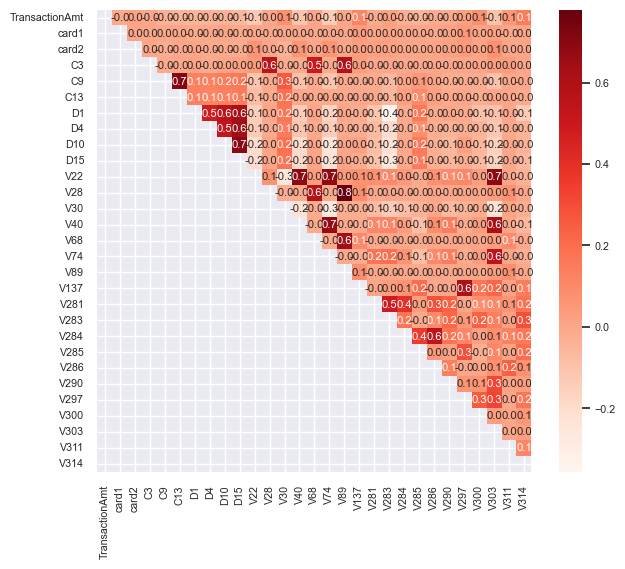

In [119]:
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

#Quitar la columna de la variable respuesta del cálculo del VIF
X = fraude_drop[columnas_numericas]
X = X.drop("isFraud", axis = 1)

corr = X.corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.set(font_scale=0.7)
plt.figure(figsize=(7,6))
sns.heatmap(corr, mask = mask, cbar=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Reds')

Se eliminarán las columnas V89, V22, C3, D15, C9, V74 porque tienen una correlación grande entre variables, esto implica que pueden ser explicadas por otras variables  y se convierte en información redundante.

In [131]:
fraude_drop = fraude_drop.drop(["V89", "V22", "C3", "D15", "C9", "V74"], axis = 1)

<Axes: >

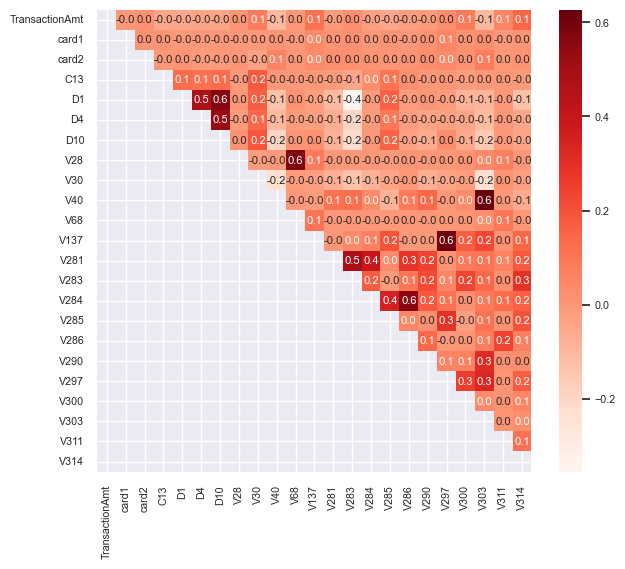

In [132]:
columnas_numericas = fraude_drop.select_dtypes(exclude=['category']).columns.tolist()

#Quitar la columna de la variable respuesta del cálculo del VIF
X = fraude_drop[columnas_numericas]
X = X.drop("isFraud", axis = 1)

corr = X.corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.set(font_scale=0.7)
plt.figure(figsize=(7,6))
sns.heatmap(corr, mask = mask, cbar=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Reds')

In [226]:
fraude_final = fraude_drop

In [227]:
fraude_final.shape

(520490, 26)

In [228]:
fraude_final["isFraud"].value_counts()

isFraud
0.0    503155
1.0     17335
Name: count, dtype: int64

Por temas de procesamiento, tomaré para entrenar los modelos solo el 15% de los datos que no son fraude.

In [229]:
fraude_no_fraude = fraude_final[fraude_final["isFraud"] == 0]

mitad_aleatoria = fraude_no_fraude.sample(frac=0.15, random_state=20) 

fraude_si_fraude = fraude_final[fraude_final["isFraud"] == 1]

fraude_final = pd.concat([mitad_aleatoria, fraude_si_fraude])
fraude_final["isFraud"].value_counts()

isFraud
0.0    75473
1.0    17335
Name: count, dtype: int64

Esta selección de datos permite contrarestar el desbalance observado en la muestra original de datos.

Se aplica OneHotEncoding a los datos categóricos

In [230]:
from sklearn.preprocessing import OneHotEncoder

In [231]:
columnas_categoricas

['card4', 'card6']

In [232]:
fraude_final.shape

(92808, 26)

In [233]:
def one_hot_encode(df, columns):
 
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_data = encoder.fit_transform(df[columns])

    encoded_columns = encoder.get_feature_names_out(columns)

    df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

    df_encoded = pd.concat([df.drop(columns=columns), df_encoded], axis=1)
    
    return df_encoded

fraude_encoded_def = one_hot_encode(fraude_final, ["card4", "card6"])

In [234]:
fraude_encoded_def.shape

(92808, 30)

In [235]:
df_fraude = fraude_encoded_def

In [236]:
df_fraude.to_csv('df_fraude.csv', index=False)

### Visualización

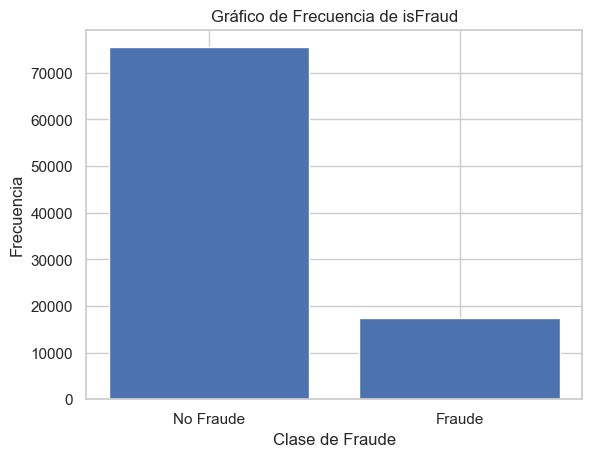

In [237]:
frecuencias = df_fraude['isFraud'].value_counts()

plt.bar(['No Fraude', 'Fraude'], frecuencias.values) 

plt.xlabel('Clase de Fraude')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencia de isFraud')

plt.show()

Se observa un desbalanceo en los datos, como es de esperarse en temas relacionados con fraude, puesto que es mucho más común la existencia de transacciones legítimas que de fraude.

In [238]:
df_fraude.describe().T

,count,mean,std,min,25%,50%,75%,max
isFraud,92808.0,0.186783,0.389740,0.000000,0.0,0.0000,0.000000,1.0
TransactionAmt,92808.0,138.483932,242.040924,0.291992,39.0,67.0625,117.046875,5276.0
card1,92808.0,9854.734375,4858.893066,1000.000000,6019.0,9633.0000,14053.000000,18395.0
card2,92808.0,358.662109,155.936768,100.000000,206.0,360.0000,500.000000,600.0
C13,92808.0,34.128296,142.445572,0.000000,1.0,3.0000,13.000000,2916.0
D1,92808.0,95.104897,156.935852,0.000000,0.0,7.0000,123.000000,640.0
D4,92808.0,109.815422,172.241333,-122.000000,0.0,26.0000,141.000000,838.0
D10,92808.0,111.204010,176.041428,0.000000,0.0,7.0000,158.000000,865.0
V28,92808.0,0.000679,0.028038,0.000000,0.0,0.0000,0.000000,2.0
V30,92808.0,0.348052,0.533745,0.000000,0.0,0.0000,1.000000,6.0


- En el 75% de los casos no se cometió fraude en las transacciones.
- En promedio las transacciones tienen valor de 139, sin embargo, esto presenta una gran desviación (240) y valor máximo bien atípico (5192).
- La card 1 presenta valores más grandes de promedio, cuartiles más grandes que la card2.
- En la mayoría de las V los valores más frecuentes son 0.

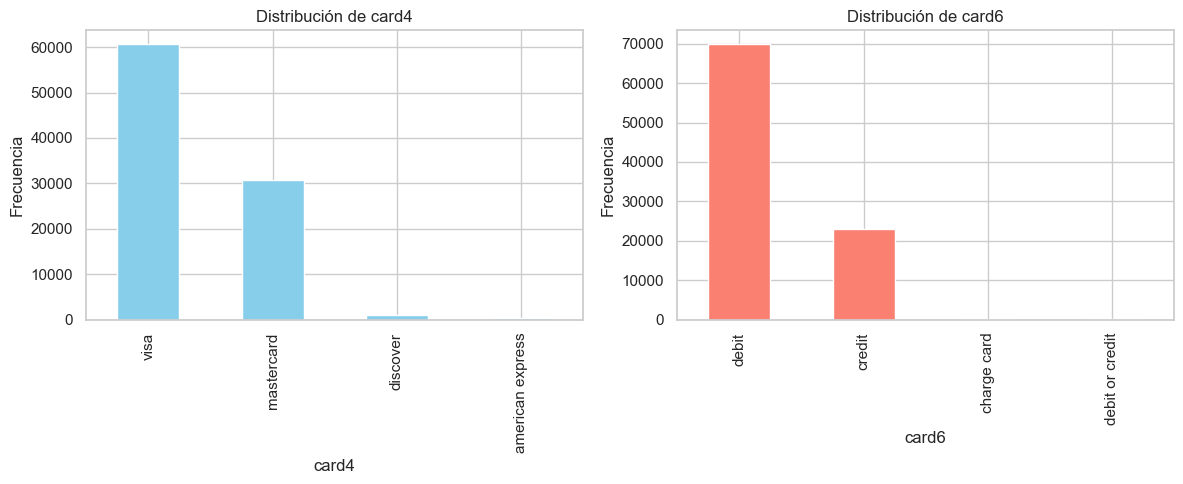

In [239]:
count_card4 = fraude_final['card4'].value_counts()
count_card6 = fraude_final['card6'].value_counts()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
count_card4.plot(kind='bar', color='skyblue')
plt.title('Distribución de card4')
plt.xlabel('card4')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
count_card6.plot(kind='bar', color='salmon')
plt.title('Distribución de card6')
plt.xlabel('card6')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


La tarjeta más común es la Visa, seguida de la Mastercard. Por otro lado, las tarjetas suelen ser de tipo débito.

Column:  TransactionAmt
Skew: 6.47
Kurtosis:  60.94


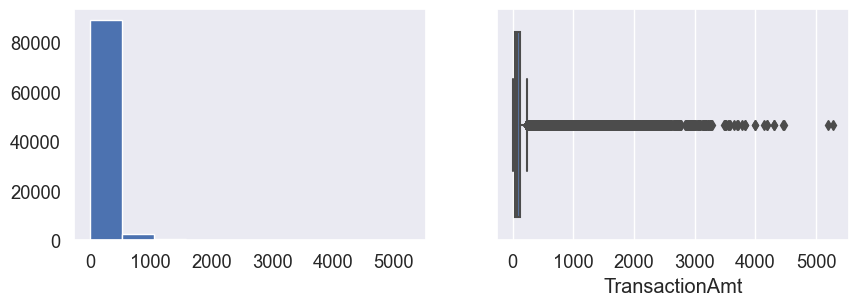

Column:  card1
Skew: -0.04
Kurtosis:  -1.12


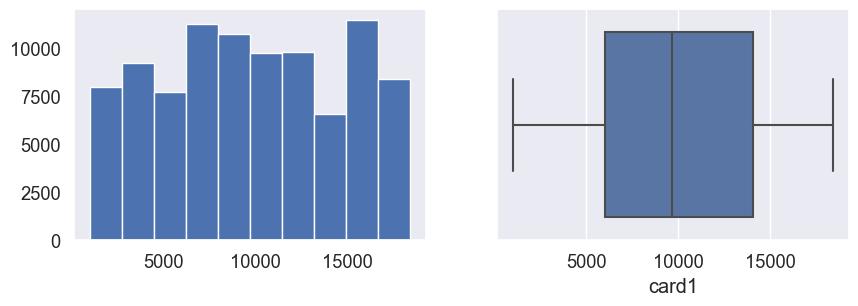

Column:  card2
Skew: -0.18
Kurtosis:  -1.32


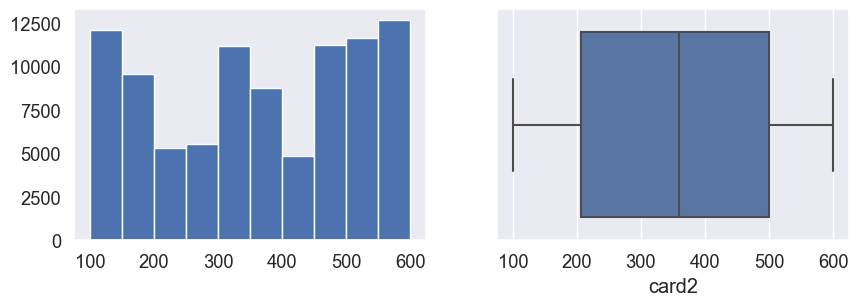

Column:  C13
Skew: 9.77
Kurtosis:  137.36


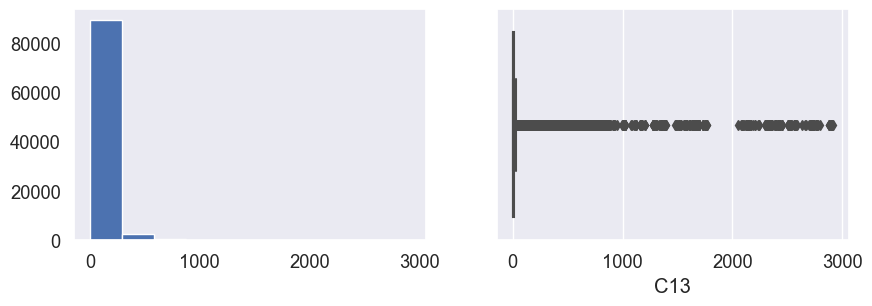

Column:  D1
Skew: 1.81
Kurtosis:  2.24


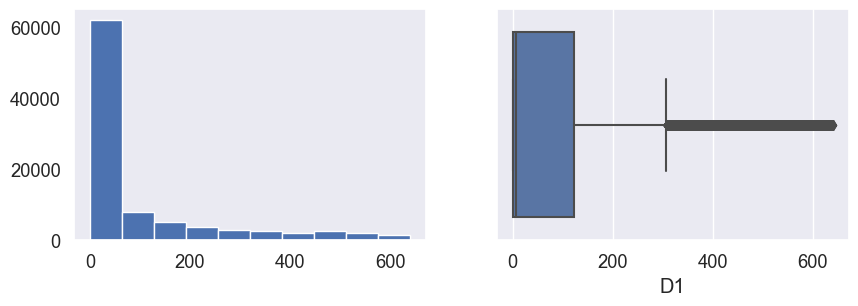

Column:  D4
Skew: 1.61
Kurtosis:  1.29


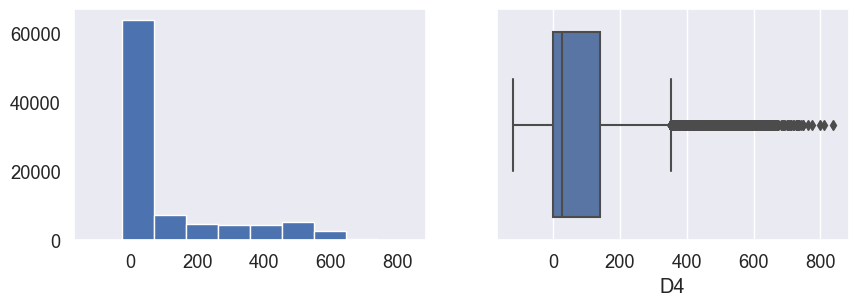

Column:  D10
Skew: 1.56
Kurtosis:  1.15


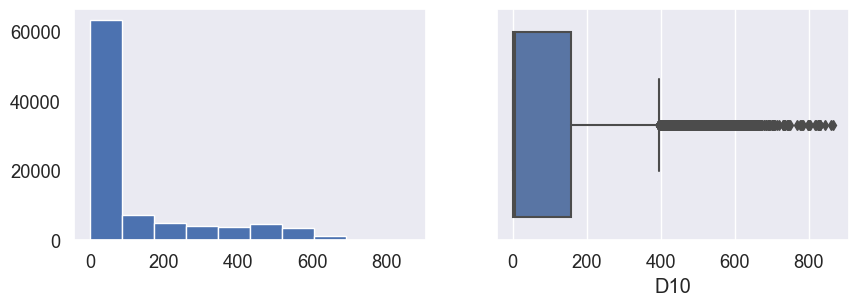

Column:  V28
Skew: 45.39
Kurtosis:  2311.72


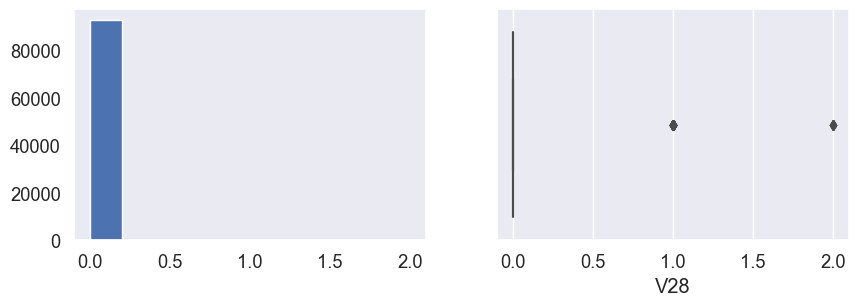

Column:  V30
Skew: 1.5
Kurtosis:  3.72


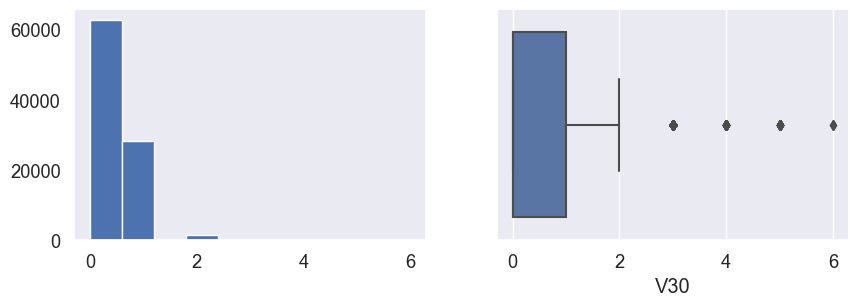

Column:  V40
Skew: 6.87
Kurtosis:  103.72


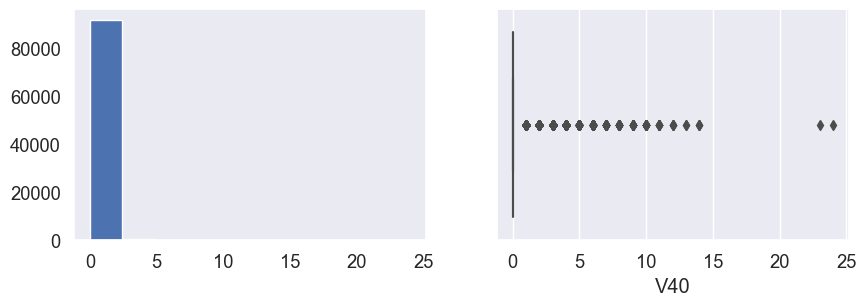

Column:  V68
Skew: 56.39
Kurtosis:  3432.7


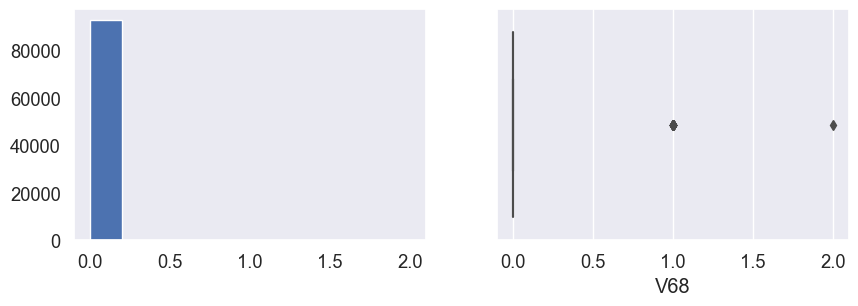

Column:  V137
Skew: 28.37
Kurtosis:  1944.01


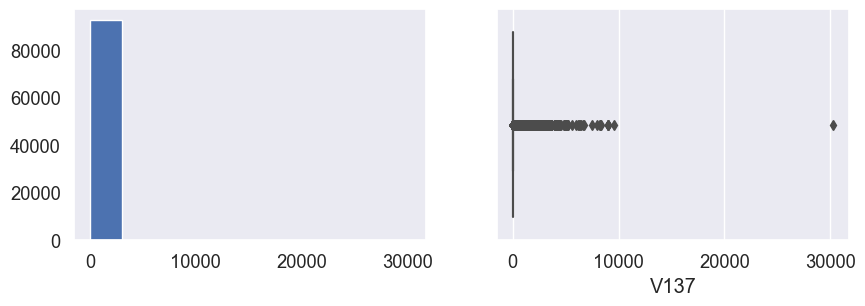

Column:  V281
Skew: 7.94
Kurtosis:  85.9


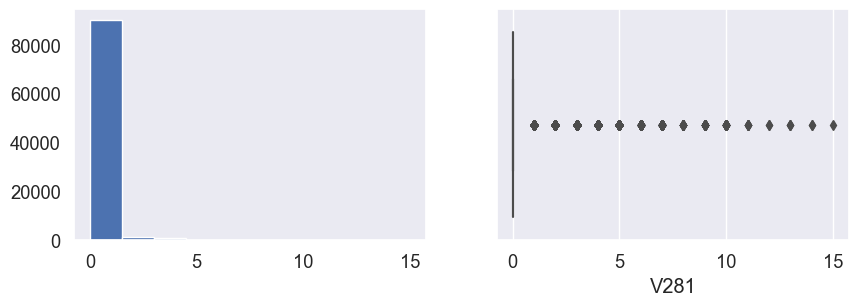

Column:  V283
Skew: 8.74
Kurtosis:  153.01


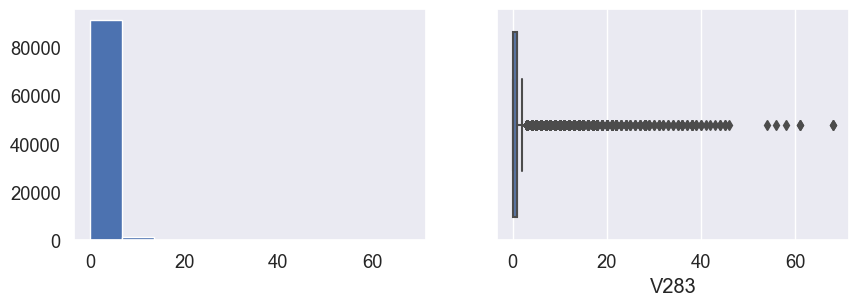

Column:  V284
Skew: 4.4
Kurtosis:  28.72


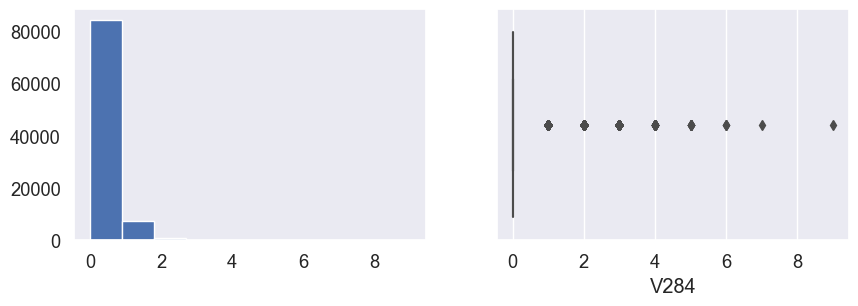

Column:  V285
Skew: 11.48
Kurtosis:  228.41


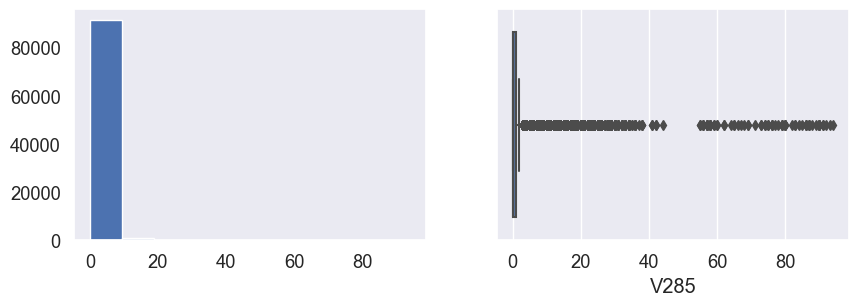

Column:  V286
Skew: 6.42
Kurtosis:  49.49


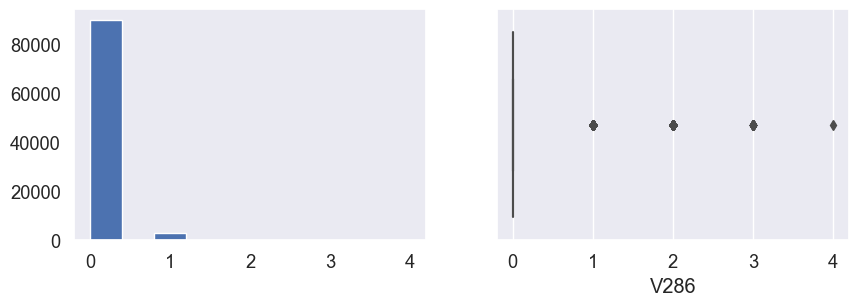

Column:  V290
Skew: 25.61
Kurtosis:  907.26


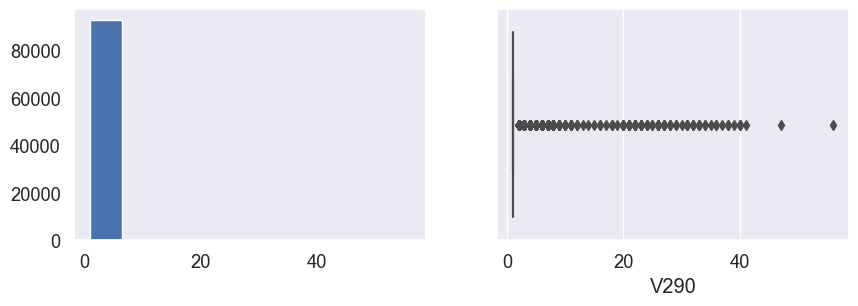

Column:  V297
Skew: 13.49
Kurtosis:  216.21


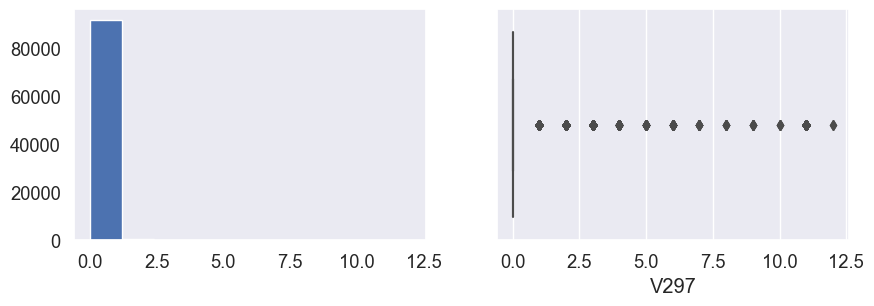

Column:  V300
Skew: 11.34
Kurtosis:  239.56


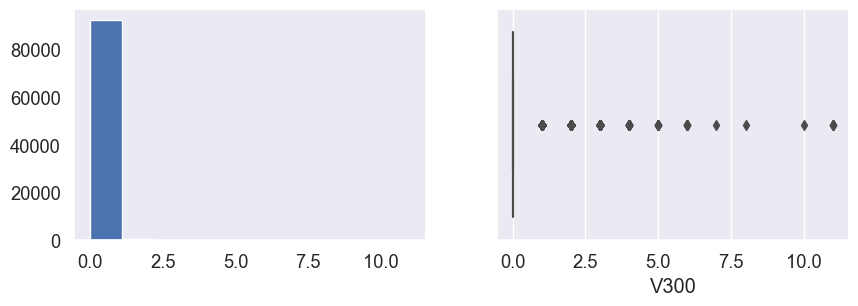

Column:  V303
Skew: 5.57
Kurtosis:  64.08


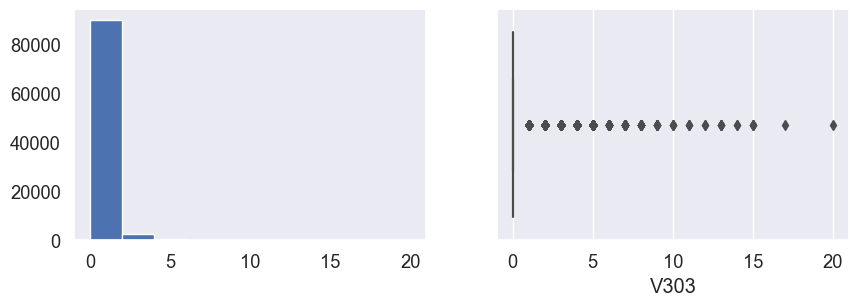

In [240]:
columnas_numericas = [col for col in df_fraude.iloc[:, :-8].select_dtypes(exclude=['category']).columns if col != 'isFraud']

sns.set(font_scale=1.2)
for col in columnas_numericas:
    print('Column: ', col)
    print('Skew:', round(df_fraude[col].skew(), 2))
    print('Kurtosis: ', round(df_fraude[col].kurtosis(), 2))
    plt.figure(figsize = (10, 3))
    plt.subplot(1, 2, 1)
    df_fraude[col].hist(grid=False)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_fraude[col])
    plt.show()

- Transacción amount presenta bastantes valores atípicos, y la mayoría de los valores de la transacción son pequeños comparados con estos.
- Las variables D de manera general presentan comportamientos similares de dispersión y se encuentran sesgados a la derecha.
- Las variables V a excepción de la V20 y V28 toman valores de 0 o cercanos en su mayoría, y cuentan con una al ta presencia de atípicos.
- La card1 y card 2 no tienen datos atípicos, la card1 presenta una distribución un poco constante de sus valores.

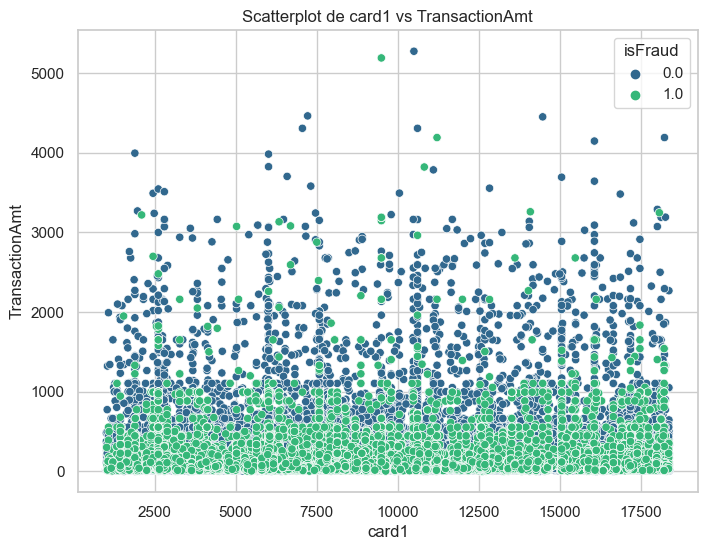

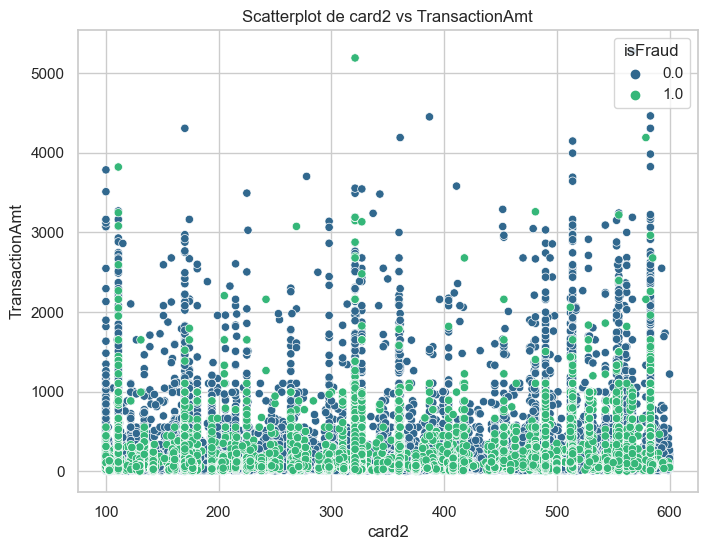

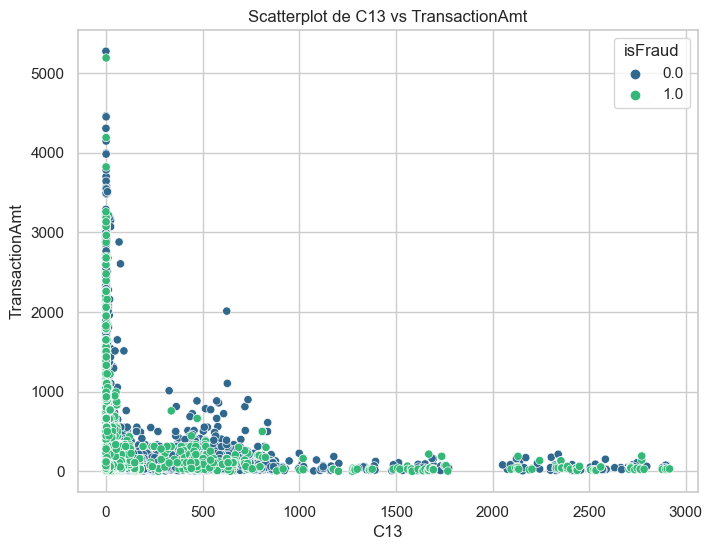

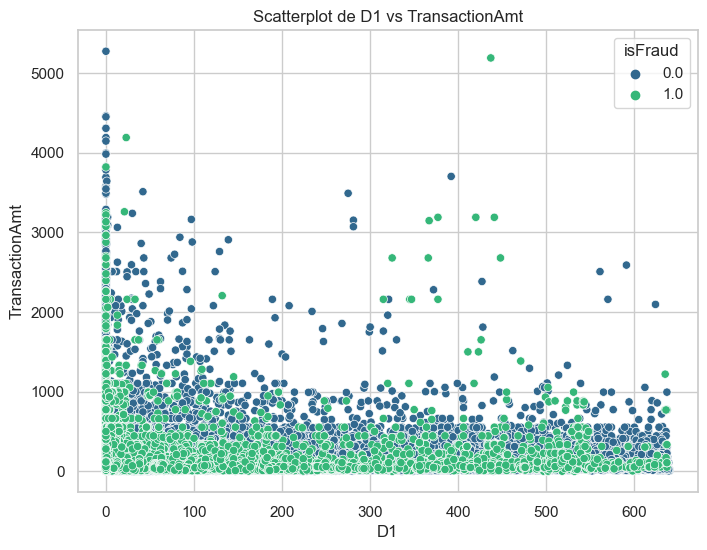

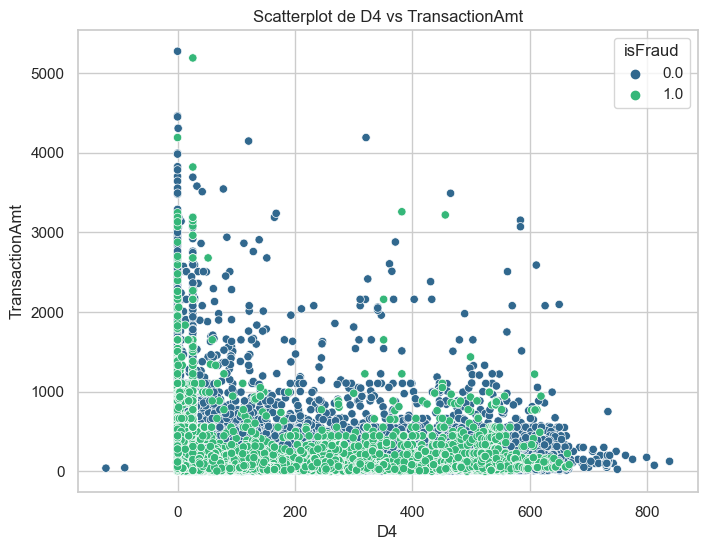

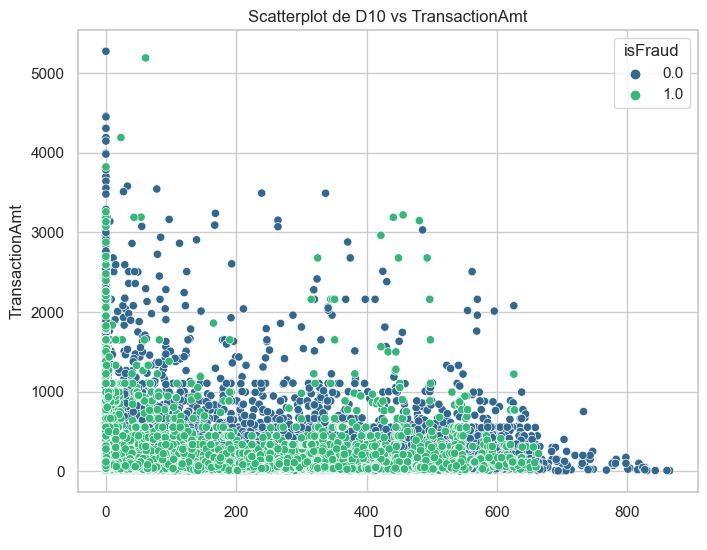

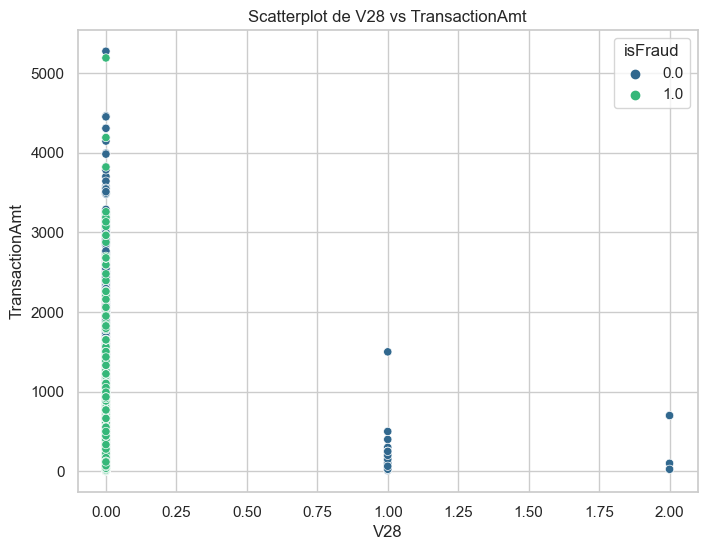

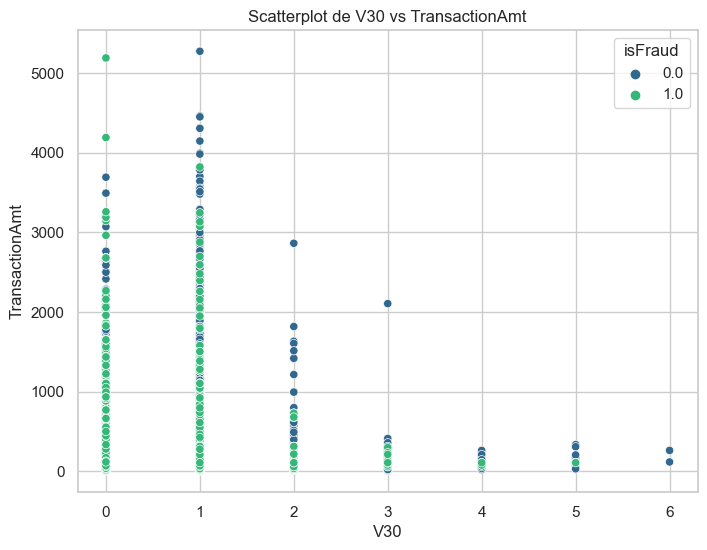

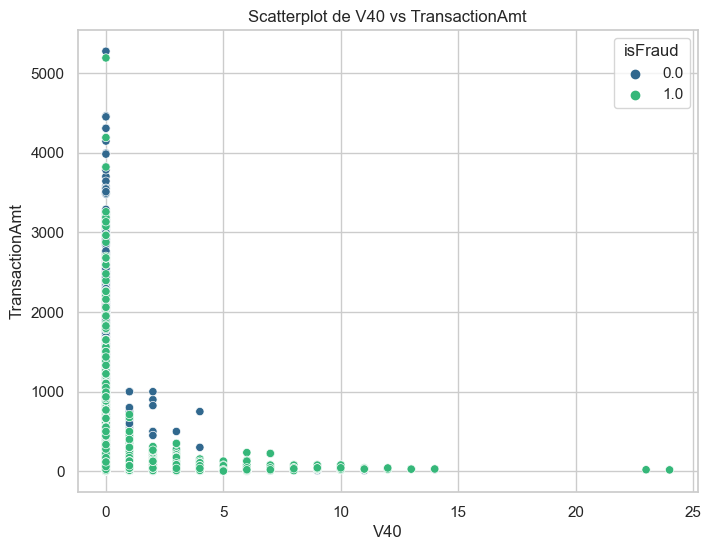

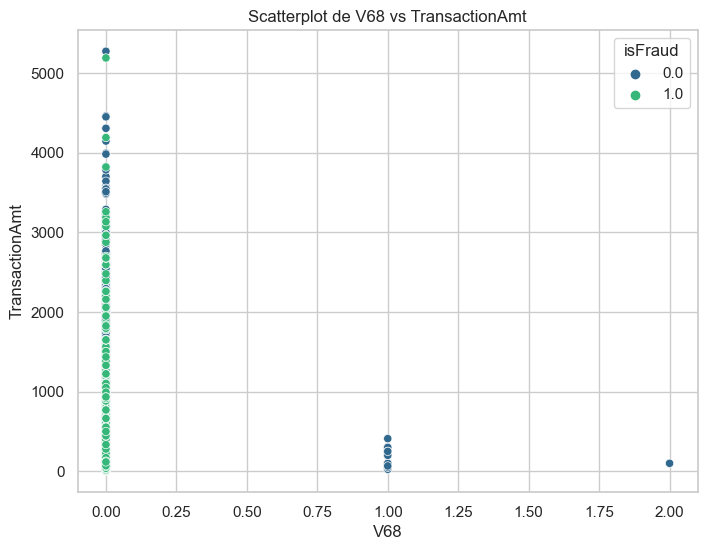

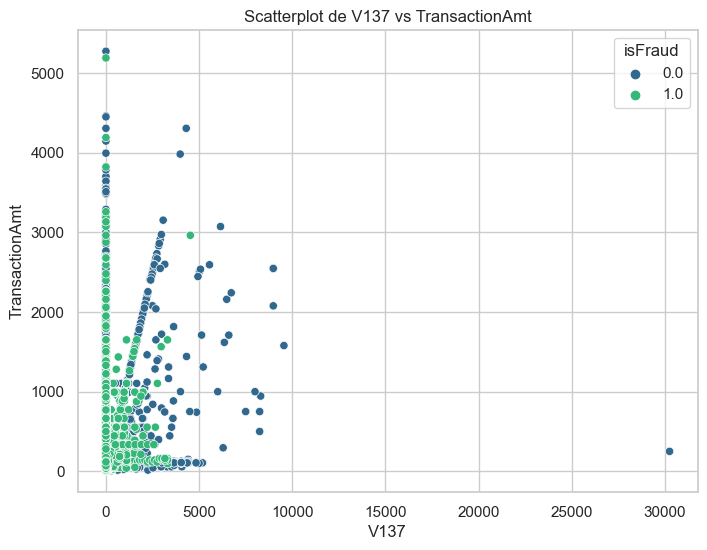

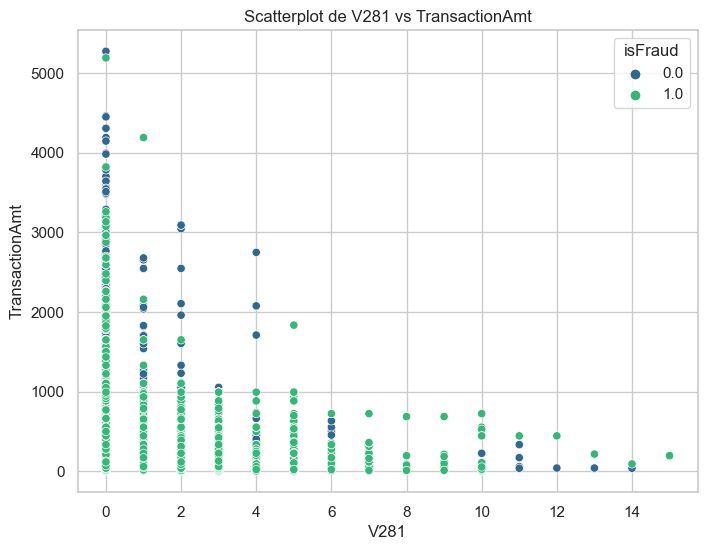

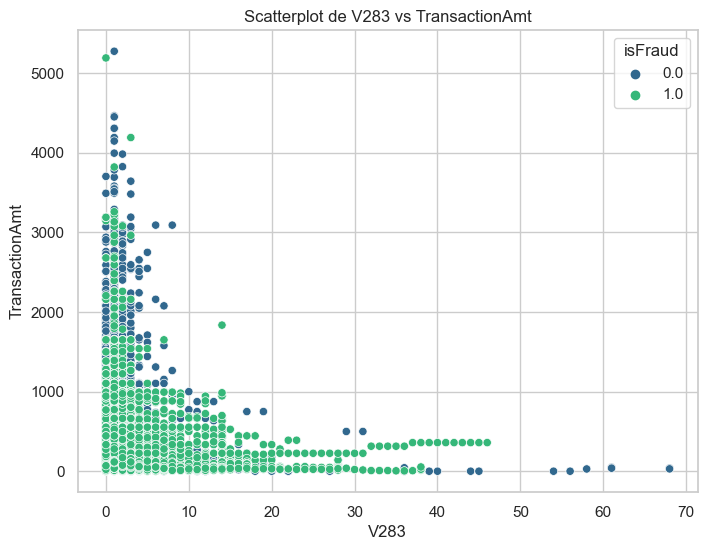

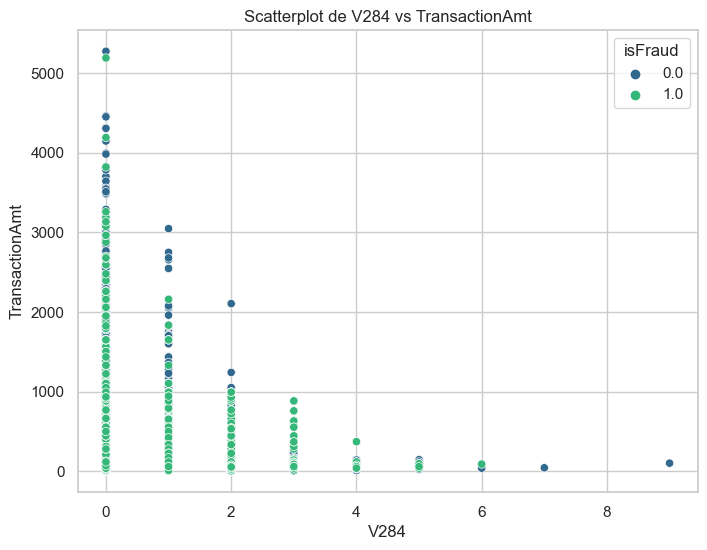

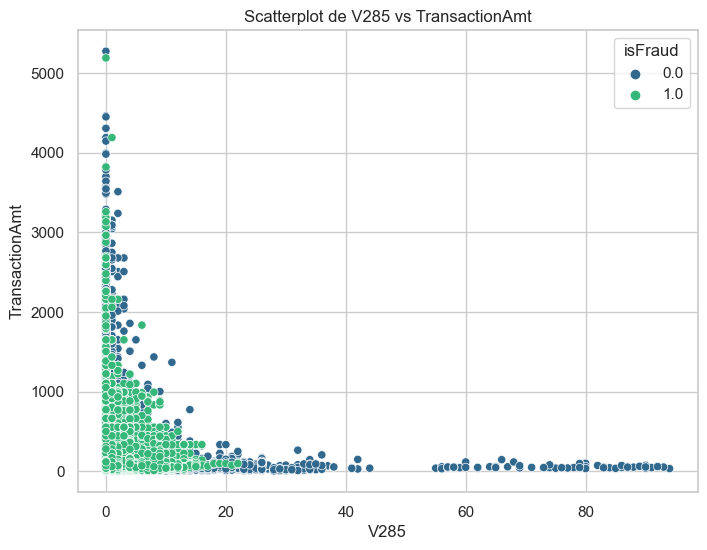

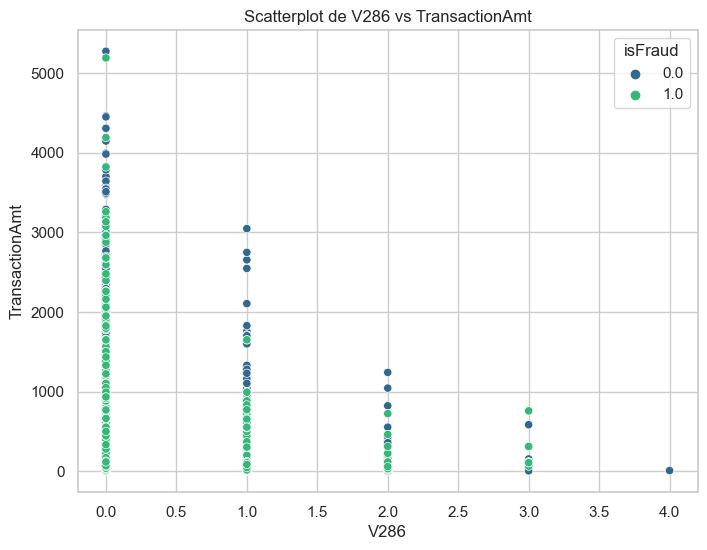

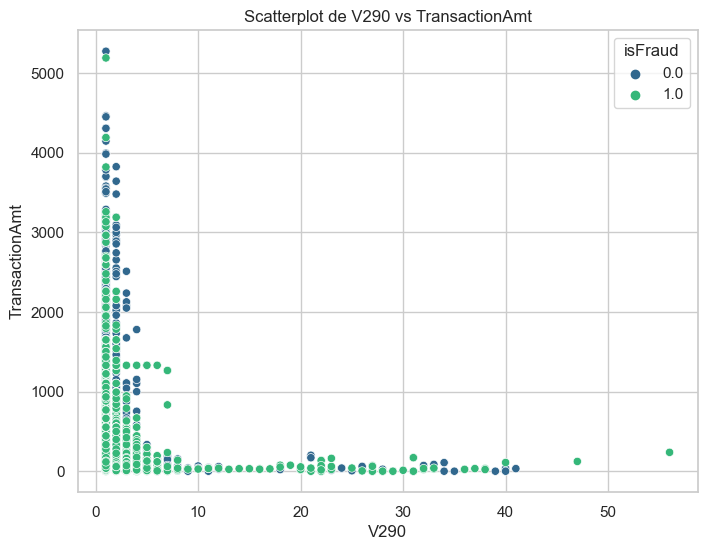

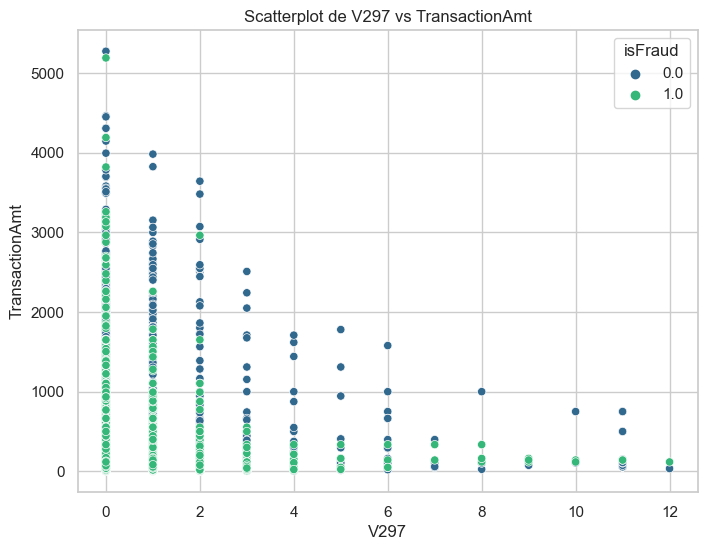

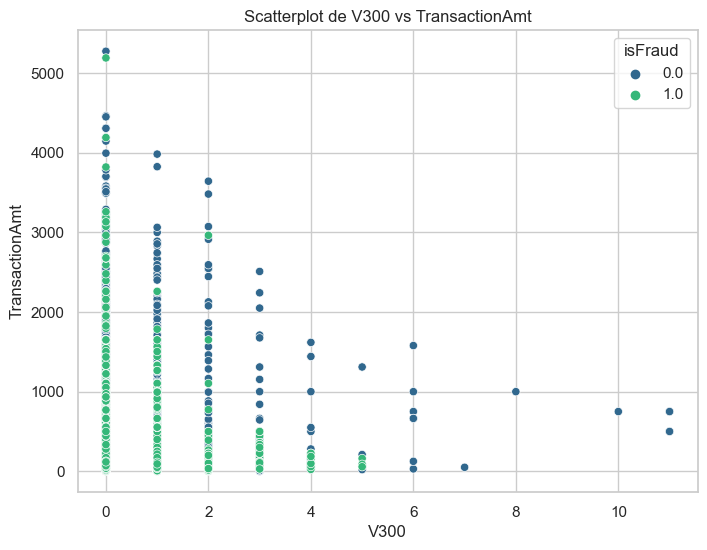

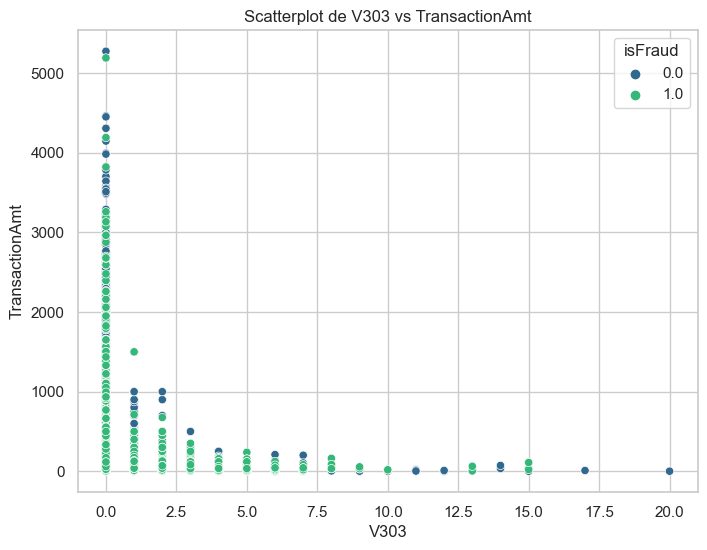

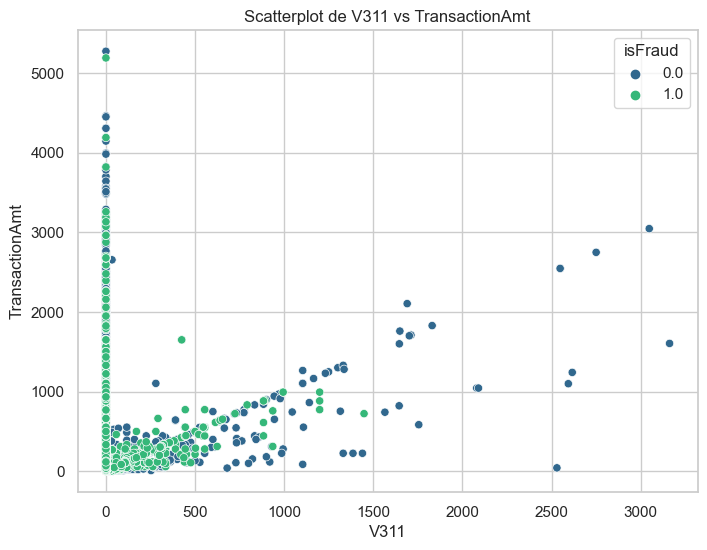

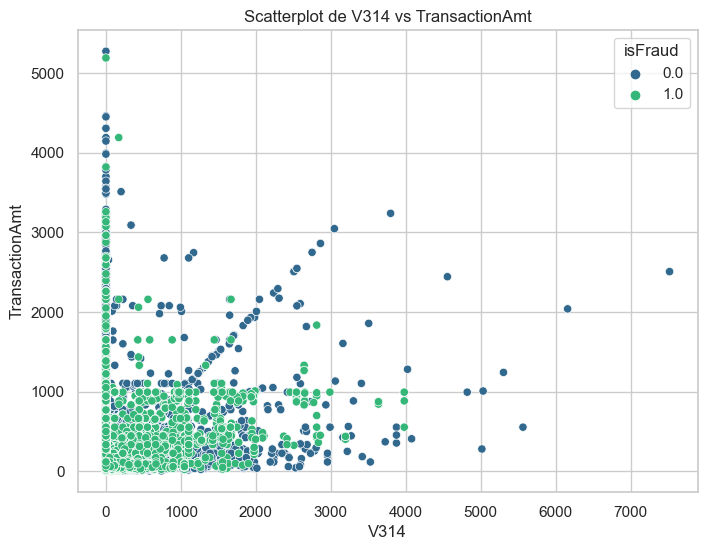

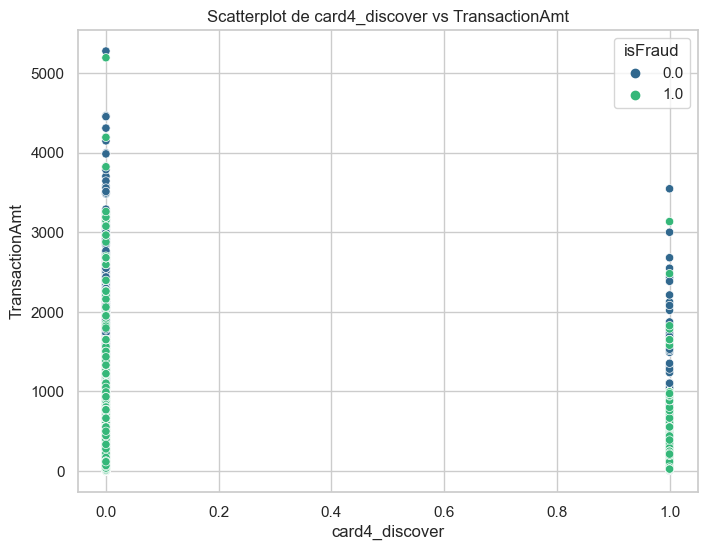

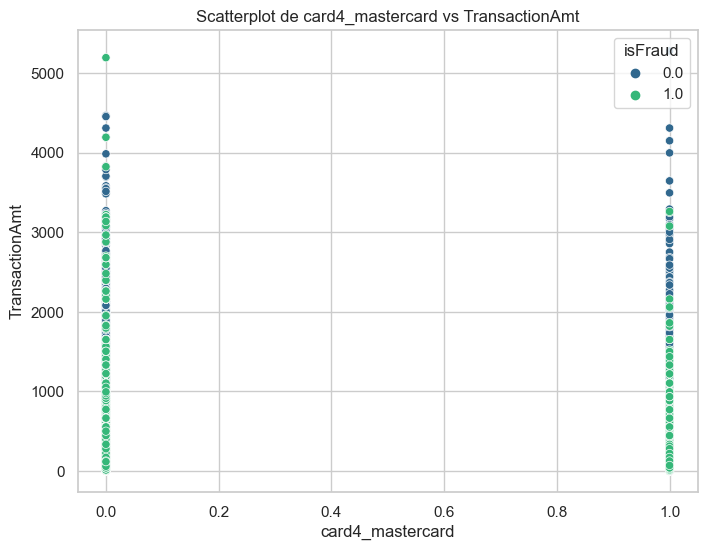

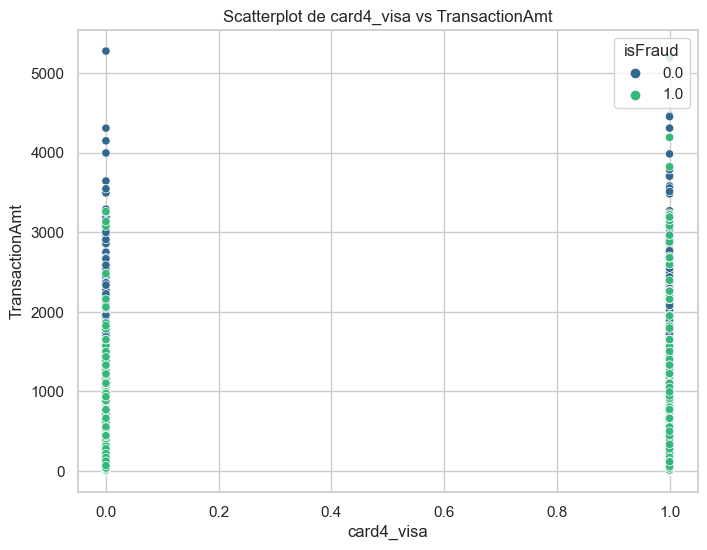

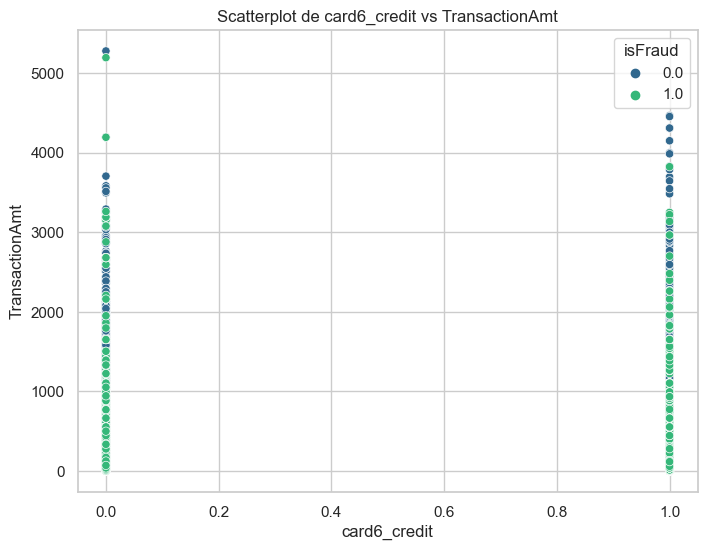

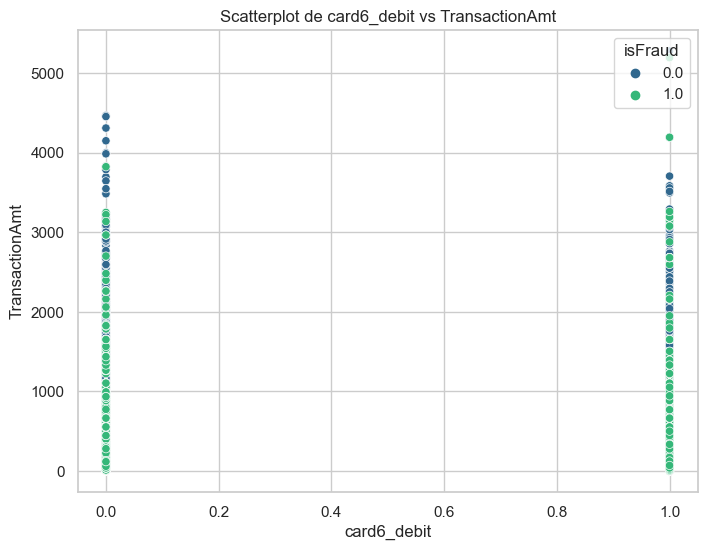

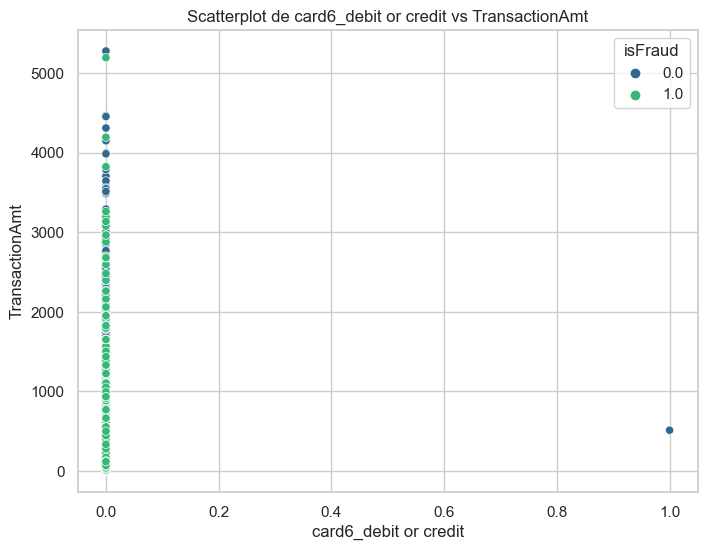

In [241]:
columnas = df_fraude.columns

sns.set(style="whitegrid")

for col in columnas:
    if col not in ['isFraud', "TransactionAmt"]:  
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_fraude, x=col, y='TransactionAmt', hue='isFraud', palette='viridis')
        plt.title(f'Scatterplot de {col} vs TransactionAmt')
        plt.xlabel(col)
        plt.ylabel('TransactionAmt')
        plt.legend(title='isFraud', loc='upper right')
        plt.show()


- Para valores grandes de V311 y de TransactionAmount la presencia de transacciones limpias es más notoria.
- Todas las transacciones de alto valor tienen V303 cero.
- A medida que V297 aumenta el valor de la transacción disminuye.
- Las transacciones de fraude se ubican en valores de V285 bajos, sin importar la cantidad de la transacción.
- No se evidencia una diferencia clara entre el fraude y las variables D y card.

## Modelado

Se realizarán distintos modelos basados para la selección del modelo con mejor comportamiento en la métrica AUC.

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [256]:
df_fraude.columns

Index(['isFraud', 'TransactionAmt', 'card1', 'card2', 'C13', 'D1', 'D4', 'D10',
       'V28', 'V30', 'V40', 'V68', 'V137', 'V281', 'V283', 'V284', 'V285',
       'V286', 'V290', 'V297', 'V300', 'V303', 'V311', 'V314',
       'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit',
       'card6_debit', 'card6_debit or credit'],
      dtype='object')

In [243]:
#Se realiza la sepación de las variables y del conjunto de entrenamiento y testing
fraude_x = df_fraude.drop('isFraud', axis=1)
fraude_y = df_fraude['isFraud']
X_train, X_test, y_train, y_test = train_test_split(fraude_x, fraude_y, random_state=0)

In [244]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(69606, 29)
(69606,)
(23202, 29)
(23202,)


#### Knn Neighbors

{'kneighborsclassifier__n_neighbors': 10}
Confusion matrix:
[[18216   687]
 [ 2228  2071]]


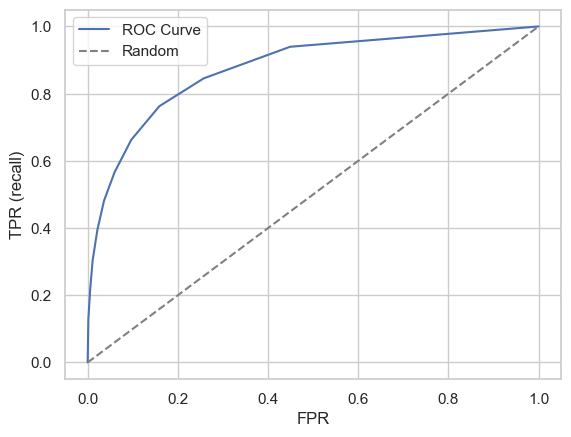

In [297]:
pipeline_knn = make_pipeline(MinMaxScaler(feature_range=(0, 1)), KNeighborsClassifier())
grid_parametros = {'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_knn = GridSearchCV(pipeline_knn, param_grid=grid_parametros, cv=5, scoring='roc_auc')
grid_knn.fit(X_train, y_train)
print(grid_knn.best_params_)

predicciones_knn = grid_knn.predict(X_test)

#Metricas
auc =roc_auc_score(y_test, predicciones_knn)
recall = recall_score(y_test, predicciones_knn)
precision = precision_score(y_test, predicciones_knn)
f1 = f1_score(y_test, predicciones_knn)

metricas_df = pd.DataFrame(columns=["Modelo",'AUC', 'Recall', 'Precision', 'F1'])
KNN = {"Modelo": "Knn", 'AUC': auc, 'Recall': recall, 'Precision': precision, 'F1': f1}

confusion_KNN = confusion_matrix(y_test, predicciones_knn)
print("Confusion matrix:\n{}".format(confusion_KNN))

# Calcular la curva ROC utilizando las probabilidades de clase
probs_knn = grid_knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_knn[:, 1])

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.legend(loc='best')
plt.show()


In [298]:
knn_params = grid_knn.best_params_

In [299]:
metricas_df.loc[len(metricas_df)] = KNN

### Naive Bayes

{'bernoullinb__alpha': 0}
Confusion matrix:
[[15871  3032]
 [ 1915  2384]]


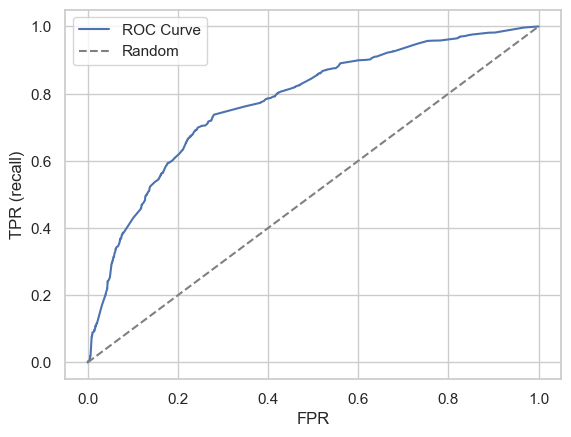

In [301]:
pipeline_NB = make_pipeline(MinMaxScaler(feature_range=(0, 1)), BernoulliNB())
grid_parametros = {'bernoullinb__alpha': [0, 0.001, 0.01, 0.1, 1]}

grid_NB = GridSearchCV(pipeline_NB, param_grid=grid_parametros, cv=5, scoring='roc_auc')
grid_NB.fit(X_train, y_train)
print(grid_NB.best_params_)

predicciones_NB = grid_NB.predict(X_test)

#Metricas
auc =roc_auc_score(y_test, predicciones_NB)
recall = recall_score(y_test, predicciones_NB)
precision = precision_score(y_test, predicciones_NB)
f1 = f1_score(y_test, predicciones_NB)

NaiveBayes = {"Modelo": "NaiveBayes", 'AUC': auc, 'Recall': recall, 'Precision': precision, 'F1': f1}

confusion_NB = confusion_matrix(y_test, predicciones_NB)
print("Confusion matrix:\n{}".format(confusion_NB))

# Calcular la curva ROC utilizando las probabilidades de clase
probs_NB = grid_NB.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_NB[:, 1])

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.legend(loc='best')
plt.show()

In [302]:
NaiveBayes

{'Modelo': 'NaiveBayes',
 'AUC': 0.6970748743751799,
 'Recall': 0.55454756920214,
 'Precision': 0.4401772525849335,
 'F1': 0.4907874420998456}

In [303]:
metricas_df.loc[len(metricas_df)] = NaiveBayes

### XGBoost

{'xgbclassifier__learning_rate': 1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 40}
Confusion matrix:
[[18106   797]
 [ 1907  2392]]


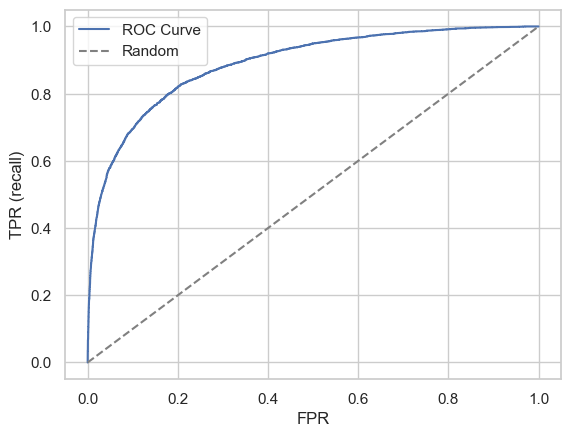

In [304]:
pipeline_XGB = make_pipeline(MinMaxScaler(feature_range=(0, 1)), xgb.XGBClassifier())
grid_parametros = {'xgbclassifier__learning_rate': [0.01, 0.1, 1], "xgbclassifier__max_depth" : [2,3,4, 5], "xgbclassifier__n_estimators" : [10,20,30,40]}

grid_XGB = GridSearchCV(pipeline_XGB, param_grid=grid_parametros, cv=5, scoring='roc_auc')
grid_XGB.fit(X_train, y_train)
print(grid_XGB.best_params_)

predicciones_XGB = grid_XGB.predict(X_test)

#Metricas
auc =roc_auc_score(y_test, predicciones_XGB)
recall = recall_score(y_test, predicciones_XGB)
precision = precision_score(y_test, predicciones_XGB)
f1 = f1_score(y_test, predicciones_XGB)

XGB = {"Modelo": "XGB", 'AUC': auc, 'Recall': recall, 'Precision': precision, 'F1': f1}

confusion_XGB = confusion_matrix(y_test, predicciones_XGB)
print("Confusion matrix:\n{}".format(confusion_XGB))

# Calcular la curva ROC utilizando las probabilidades de clase
probs_XGB = grid_XGB.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_XGB[:, 1])

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.legend(loc='best')
plt.show()

In [306]:
grid_XGB.best_params_

{'xgbclassifier__learning_rate': 1,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__n_estimators': 40}

In [307]:
metricas_df.loc[len(metricas_df)] = XGB

### SVM

Con el tamaño inicial, no alcanzó a terminar. Se procede a disminuir el tamaño.

{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Confusion matrix:
[[18796   107]
 [ 4002   297]]


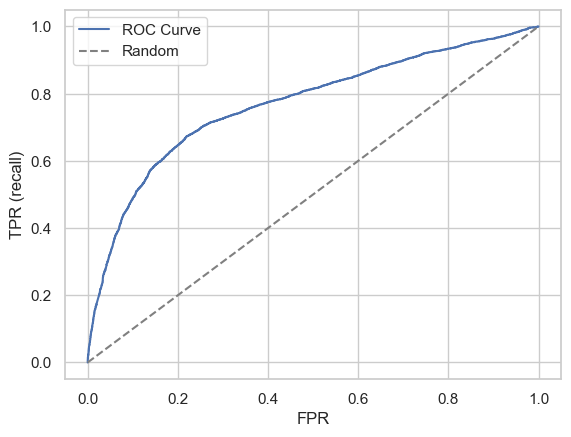

In [328]:
pipeline_SVC = make_pipeline(MinMaxScaler(feature_range=(0, 1)), SVC(probability=True))
grid_parametros = {'svc__C': [0.01, 0.1, 1], "svc__gamma": [0.01, 0.1, 1], "svc__kernel":  ["rbf"]}

grid_SVC = GridSearchCV(pipeline_SVC, param_grid=grid_parametros, cv=5, scoring='roc_auc')
grid_SVC.fit(X_train[:5000], y_train[:5000])
print(grid_SVC.best_params_)

predicciones_SVC = grid_SVC.predict(X_test)

# Metricas
auc = roc_auc_score(y_test, predicciones_SVC)
recall = recall_score(y_test, predicciones_SVC)
precision = precision_score(y_test, predicciones_SVC)
f1 = f1_score(y_test, predicciones_SVC)

# Guardar los resultados en un diccionario
SVC_ = {"Modelo": "SVC", 'AUC': auc, 'Recall': recall, 'Precision': precision, 'F1': f1}

confusion_SVC = confusion_matrix(y_test, predicciones_SVC)
print("Confusion matrix:\n{}".format(confusion_SVC))

# Calcular la curva ROC utilizando las probabilidades de clase
probs_SVC = grid_SVC.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_SVC[:, 1])

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.legend(loc='best')
plt.show()


In [329]:
grid_SVC.best_params_

{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}

In [318]:
metricas_df.loc[len(metricas_df)] = SVC

### MLP

{'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': 10}
Confusion matrix:
[[17814  1089]
 [ 2578  1721]]


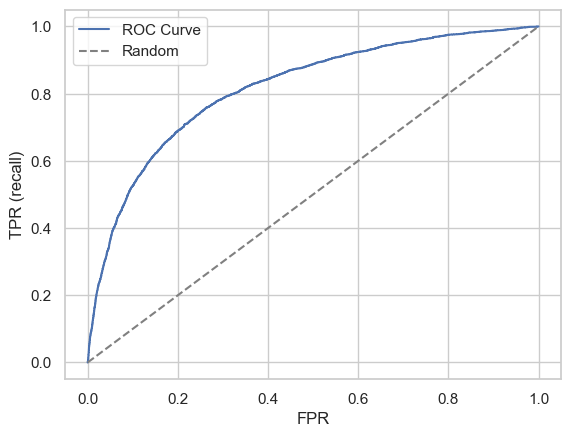

In [319]:
pipeline_MLP = make_pipeline(MinMaxScaler(feature_range=(0, 1)), MLPClassifier(solver = "lbfgs", max_iter=400))
grid_parametros = {'mlpclassifier__activation': ["relu", "tanh", "sigmoid"], "mlpclassifier__alpha" : [0.01, 0.1],
                   "mlpclassifier__hidden_layer_sizes": [10,50] }
grid_MLP = GridSearchCV(pipeline_MLP, param_grid=grid_parametros, cv=5, scoring='roc_auc')
grid_MLP.fit(X_train[:10000], y_train[:10000])
print(grid_MLP.best_params_)

predicciones_MLP = grid_MLP.predict(X_test)

#Metricas
auc =roc_auc_score(y_test, predicciones_MLP)
recall = recall_score(y_test, predicciones_MLP)
precision = precision_score(y_test, predicciones_MLP)
f1 = f1_score(y_test, predicciones_MLP)

MLP = {"Modelo": "MLP", 'AUC': auc, 'Recall': recall, 'Precision': precision, 'F1': f1}

confusion_MLP = confusion_matrix(y_test, predicciones_MLP)
print("Confusion matrix:\n{}".format(confusion_MLP))

# Calcular la curva ROC utilizando las probabilidades de clase
probs_MLP = grid_MLP.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_MLP[:, 1])

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.legend(loc='best')
plt.show()

In [320]:
grid_MLP.best_params_

{'mlpclassifier__activation': 'tanh',
 'mlpclassifier__alpha': 0.1,
 'mlpclassifier__hidden_layer_sizes': 10}

In [321]:
metricas_df.loc[len(metricas_df)] = MLP

In [322]:
metricas_df

,Modelo,AUC,Recall,Precision,F1
0,Knn,0.722698,0.481740,0.750906,0.586935
1,NaiveBayes,0.697075,0.554548,0.440177,0.490787
2,XGB,0.757123,0.556408,0.750078,0.638889
3,SVC,0.531713,0.069086,0.735149,0.126302
4,MLP,0.671358,0.400326,0.612456,0.484175


- XGB tiene el AUC más alto entre todos los modelos, esto se aprecia en la curva ROC puesto que es el modelo con la línea más cerca a la esquina superior izquierda. Este a su vez tiene el mejor recall, el mejor F1 y la segunda mejor precision.
- El segundo mejor modelo en términos de AUC es Knn con 10 vecinos, y presenta un rendimiento competitivo con XGBoost.

El mejor modelo basado en la optimización del AUC es: **XGB** con parámetros learning_rate: 1, max_depth: 5, n_estimators: 40. El AUC en el conjunto de testing es 0.75.